In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import random
import sklearn
import collections
from sklearn.model_selection import train_test_split
import json
import pylab
import tensorflow as tf
import tensorflow.math as tfmath
import tensorflow.keras as keras
from scipy.optimize import curve_fit
from tensorflow.keras import layers, Model
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from sklearn.metrics import roc_curve, auc
import sklearn.metrics as sk
import qkeras
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu

2024-03-21 18:42:39.323343: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-21 18:42:39.415085: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
f=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/background_for_training.h5','r')
Dataset=np.array(f["Particles"])

Data_Train=Dataset[0:2000000,:,0:3]
Data_Test=Dataset[2000001:3600000,:,0:3]
Data_Validate=Dataset[3600001:4000000,:,0:3]

Data_Train_Flat=np.reshape(Data_Train,(-1,57))
Data_Val_Flat=np.reshape(Data_Validate,(-1,57))
Data_Test_Flat=np.reshape(Data_Test,(-1,57))

h_to_Tau_Tau=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/hToTauTau_13TeV_PU20.h5','r')
A_to_4_l=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/Ato4l_lepFilter_13TeV.h5','r')
hC_to_Tau_Nu=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/hChToTauNu_13TeV_PU20.h5','r')
lepto=h5py.File('/eos/home-w/wsherman/AD_Work/n_tuples/40MHZ_data/leptoquark_LOWMASS_lepFilter_13TeV.h5','r')

h_tt_set=np.array(h_to_Tau_Tau["Particles"])
hC_tn_set=np.array(hC_to_Tau_Nu["Particles"])
A_4l_set=np.array(A_to_4_l["Particles"])
lepto_set=np.array(lepto["Particles"])
sets=[h_tt_set,hC_tn_set,A_4l_set,lepto_set]



signals=[]
for j, subset in enumerate(sets):
    signals+=[np.reshape(subset[:,:,0:3],(-1,57))]


sig_label=['Backround','h_tt','hC_tn','A_4l','leptoquark']

In [3]:

class Sampling(keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



def make_Qencoder(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs=keras.Input(shape=(input_dim))

    x=QDense(h_dim_1,kernel_quantizer=quantized_bits(6),bias_quantizer=quantized_bits(6))(inputs)
    x=QActivation("quantized_relu(6)")(x)
    x=QDense(h_dim_2,kernel_quantizer=quantized_bits(6),bias_quantizer=quantized_bits(6))(x)
    x=QActivation("quantized_relu(6)")(x)
    z_mean=QDense(latent_dim, kernel_quantizer=quantized_bits(6),bias_quantizer=quantized_bits(6))(x)
    z_logvar=QDense(latent_dim, kernel_quantizer=quantized_bits(6),bias_quantizer=quantized_bits(6))(x)
    z=Sampling()([z_mean,z_logvar])
    encoder=keras.Model(inputs,[z_mean,z_logvar,z],name='encoder')
    return encoder




def make_Qdecoder(input_dim,h_dim_1,h_dim_2,latent_dim):
    inputs=keras.Input(shape=(latent_dim))
    x=QDense(h_dim_2, kernel_quantizer=quantized_bits(6),bias_quantizer=quantized_bits(6))(inputs)
    x=QActivation("quantized_relu(6)")(x)
    x=QDense(h_dim_1,kernel_quantizer=quantized_bits(6),bias_quantizer=quantized_bits(6))(x)
    x=QActivation("quantized_relu(6)")(x)
    z=QDense(input_dim,kernel_quantizer=quantized_bits(6),bias_quantizer=quantized_bits(6))(x)
    decoder=keras.Model(inputs,z,name='decoder')
    return decoder


class QVAE_Model(keras.Model):
    def __init__(self,encoder,decoder,**kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.beta=1

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]
    
    def set_beta(self,beta):
        self.beta=beta
    
    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            #making a masked loss function
            mask = K.cast(K.not_equal(data, 0), K.floatx())
            
            reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))
            reconstruction_loss *=(1-self.beta)

            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *=self.beta


            total_loss = reconstruction_loss + kl_loss
            
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reco_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        z_mean, z_log_var, z = self.encoder(data)
        
        reconstruction = self.decoder(z)
        mask = K.cast(K.not_equal(data, 0), K.floatx())
        reconstruction_loss = tf.reduce_mean(tf.reduce_sum(keras.losses.mse(mask*data, mask*reconstruction)))
        
        reconstruction_loss*=(1-self.beta)

        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        
        #KL loss changed abck to sum as in paper
        kl_loss = tf.reduce_sum(kl_loss)
        
        kl_loss *=self.beta
        
        total_loss = reconstruction_loss + kl_loss
        return {
            "loss": total_loss,
            "reco_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

    def call(self, data):
        z_mean,z_log_var,x = self.encoder(data)
        reconstruction = self.decoder(x)
        return {
            "z_mean": z_mean,
            "z_log_var": z_log_var,
            "reconstruction": reconstruction
        }

        
    

def total_loss(signal,predict,z_mean,z_log_var,beta):
    re_loss=np.mean((signal-predict)**2)
    kl_loss=np.sum(-0.5 * (1 + z_log_var - (z_mean)**2 - np.exp(z_log_var)))
    tot_loss=re_loss+beta*kl_loss
    return tot_loss
def AD_score(s,p,z_m,z_log,beta):
    mask = (s!=0)
    
    _s=s*mask
    _p=p*mask
    
    p=mask*p
    return total_loss(_s,_p,z_m,z_log,beta)

def AD_score_MSE(s,p):
    mask = (s!=0)
    s1=s*mask
    p1=p*mask
    re_loss=np.mean((s1-p1)**2)
    return re_loss

def AD_score_KL(z_mean,z_log_var):
    kl_loss=np.mean(-0.5 * (1 + z_log_var - (z_mean)**2 - np.exp(z_log_var)))
    return kl_loss

def AD_score_Rz(z_mean,z_log_var):
    Rz_loss=np.mean((z_mean**2)/(np.exp(z_log_var)))
    return Rz_loss

def AD_score_CKL(z_mean,z_log_var):
    CKL=np.mean(z_mean**2)
    return CKL
    

class Model_Evaluator():
  def __init__(self,model_path,backround,signal,title='placeholder',save=False,labels=None):

    
    vae_enc=make_Qencoder(57,32,16,3)
    vae_dec=make_Qdecoder(57,32,16,3)
    #vae_enc=make_encoder2(57,16,3)
    #vae_dec=make_decoder2(57,16,3)
    self.model=QVAE_Model(vae_enc,vae_dec)
    self.model.load_weights(model_path)
    self.encoder=self.model.get_layer('encoder')
    self.signal=signal
    self.backround=backround
    self.br_loss=[]
    self.signal_loss=[]
    self.backround_outputs=[]
    self.signal_outputs=[]
    self.title=title
    self.saveplots=save
    self.labels=labels

  def calculate_loss(self,l_type):
    
    br=self.backround
    
    if l_type=='CKL':
        br_latent=np.array(self.encoder.predict(br))
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_CKL(br_latent[0][i],br_latent[1][i])
            l+=[loss]
        self.br_loss= l

        
        for i, batch in enumerate(self.signal):
            sg_latent=np.array(self.encoder.predict(batch))
        
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_CKL(sg_latent[0][i],sg_latent[1][i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]            
            
            

    
    
    if l_type=='KL':
        br_latent=np.array(self.encoder.predict(br))
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_KL(br_latent[0][i],br_latent[1][i])
            l+=[loss]
        self.br_loss= l

        
        for i, batch in enumerate(self.signal):
            sg_latent=np.array(self.encoder.predict(batch))
        
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_KL(sg_latent[0][i],sg_latent[1][i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]
    
    if l_type=='Rz':
        br_latent=np.array(self.encoder.predict(br))
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_Rz(br_latent[0][i],br_latent[1][i])
            l+=[loss]
        self.br_loss= l

        
        for i, batch in enumerate(self.signal):
            sg_latent=np.array(self.encoder.predict(batch))
        
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_Rz(sg_latent[0][i],sg_latent[1][i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]
    
    
    
    
    if l_type=='MSE':
        br_predict=np.array(self.model.predict(br)['reconstruction'])
        l=[]
        for i in range(0,br.shape[0]):
            loss=AD_score_MSE(br[i],br_predict[i])
            l+=[loss]
        self.br_loss= l
        
        for i, batch in enumerate(self.signal):
            sg_predict=np.array(self.model.predict(batch)['reconstruction'])      
            l=[]
        
            for i in range(0,batch.shape[0]):
                loss=AD_score_MSE(batch[i],sg_predict[i])
                l+=[loss]
    
            sg_loss= l
        
            self.signal_loss+=[sg_loss]

    return [self.br_loss,self.signal_loss]


  def histogram(self,bins):
    plt.hist(self.br_loss,bins=bins,histtype='step',label='backround num_events:{}'.format(len(self.br_loss)))
    for i,batch in enumerate(self.signal_loss):
      plt.hist(batch,bins=bins,histtype='step',label=str(self.labels[i+1])+" num_events:{}".format(len(batch)))
    plt.xlabel('loss')
    plt.ylabel('Frequency')
    plt.yscale('log')
    plt.title("{}_Hist".format(self.title))
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_Hist.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()

  def ROC(self):
    plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
    for j, batch in enumerate(self.signal_loss):
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data)
    #auc=np.trapz(tpr,fpr)
      auc=sk.roc_auc_score(truth,ROC_data)
      plt.plot(fpr,tpr,label=self.labels[j+1]+": "+str(auc))

    plt.xlabel('fpr')
    plt.semilogx()
    plt.ylabel('trp')
    plt.semilogy()
    plt.title("{}_ROC".format(self.title))
    plt.vlines(10**-5,0,1,colors='r',linestyles='dashed')
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_ROC.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()

  def SIC(self):
    #plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
    for j, batch in enumerate(self.signal_loss):
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data)
    #auc=np.trapz(tpr,fpr)
      auc=sk.roc_auc_score(truth,ROC_data)
      plt.plot(fpr,tpr/np.sqrt(fpr),label=self.labels[j+1])

    plt.xlabel('fpr')
    plt.semilogx()
    plt.ylabel('trp/sqrt(fpr)')
    plt.title("{}_SIC".format(self.title))
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_SIC.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()
    
  def Sensitivity(self):
    #plt.plot(np.linspace(0,1,1000),np.linspace(0,1,1000),'--',label='diagonal')
    for j, batch in enumerate(self.signal_loss):
      truth=[]
      for i in range(len(self.br_loss)):
        truth+=[0]
      for i in range(len(batch)):
        truth+=[1]
      ROC_data=np.concatenate((self.br_loss,batch))
      fpr,tpr,x=sk.roc_curve(truth,ROC_data)
    #auc=np.trapz(tpr,fpr)
      auc=sk.roc_auc_score(truth,ROC_data)
      plt.plot(fpr,tpr/fpr,label=self.labels[j+1])

    plt.xlabel('fpr')
    plt.semilogx()
    plt.ylabel('trp/fpr')
    plt.semilogy()
    plt.title("{}_Sensitivity".format(self.title))
    plt.legend()
    if self.saveplots==True:
      plt.savefig("/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/VAE_Varying_Plots/{}_tpr_fpr.png".format(self.title), format="png", bbox_inches="tight")
    plt.show()
    
    
    
  def S_F(self,true_br_rate,desired_br_rate):
    N=len(self.br_loss)
    n=int(np.round(N*(desired_br_rate/true_br_rate)))
    br=self.br_loss
    br.sort()
    AD=br[-(n+1)]
    print(AD)
    sensitivity=[]
    for i,losses in enumerate(self.signal_loss):
        N=len(losses)
        n=0
        for loss in losses:
            if loss>=AD:
                n+=1
        sen=n/N
        sensitivity+=[sen]
    self.signal_sensitivity=sensitivity
    print(self.signal_sensitivity)
    
  
  def Find_AD_Cutoff(self,br_rate,desired_rate,starting_AD):
    N=self.backround.shape[0]
    AD_max=starting_AD
    AD_List=np.linspace(0,AD_max,num=1000)
    best_AD=0
    for i,AD in enumerate(np.flip(AD_List)):
      n=0
      for loss in self.br_loss:
        if loss>=AD:
          n+=1
      sigrate=br_rate*n/N
      if sigrate<=desired_rate:
        best_AD=AD
      if sigrate>desired_rate:
        break
    self.AD_cutoff=best_AD
    return best_AD
    
  def calculate_sensitivity(self,br_rate):
    AD=self.AD_cutoff
    sensitivity=[]
    for i,losses in enumerate(self.signal_loss):
        N=len(losses)
        n=0
        for loss in losses:
            if loss>=AD:
                n+=1
        sen=n/N
        sensitivity+=[sen]
    self.signal_sensitivity=sensitivity
    print(self.signal_sensitivity)
    
    
        
    
        



In [4]:
vae_enc=make_encoder(57,32,16,3)
vae_dec=make_decoder(57,32,16,3)
#vae_enc=make_encoder2(57,16,3)
    #vae_dec=make_decoder2(57,16,3)
model=VAE_Model(vae_enc,vae_dec)
model.load_weights('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/Good_models/40_MHZ_VAE_beta_0.83_batchnorm/')
a=model(np.zeros((1,57)))
tf.keras.utils.plot_model(vae_dec,to_file="/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/analyses_plots/model_plot.png",show_shapes=True,expand_nested=True,show_layer_names=True)

NameError: name 'make_encoder' is not defined

10642/10642 [==============================] - 45s 4ms/step
0.0037114024
[0.0003761122434661347, 0.0006773891449376012, 0.0015365648841322876, 0.0008809434316857733]


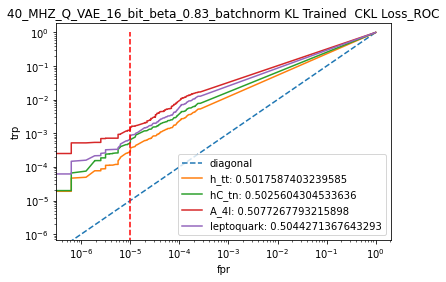

In [6]:
Losses=['CKL']
for string in Losses:
    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/Different_VAE_Models/Q_keras_16_bit_non_normed_new_beta_0.83_v4_no_batchnorm/',Data_Test_Flat,signals,title='40_MHZ_Q_VAE_16_bit_beta_0.83_batchnorm KL Trained  {} Loss'.format(string), save=True,labels=sig_label)
    a=evaluation.calculate_loss(string)
    #evaluation.Sensitivity()
    evaluation.S_F(40*10**6,40*10)
    #evaluation.histogram(bins=100)
    evaluation.ROC()

In [ ]:
Losses=['MSE']
for string in Losses:
    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/Different_VAE_Models/Q_keras_non_normed_new_beta_0.83_v4_no_batchnorm/',Data_Test_Flat,signals,title='Q_Keras 40_MHZ_VAE  {} Loss'.format(string), save=True,labels=sig_label)
    a=evaluation.calculate_loss(string)
    #evaluation.Sensitivity()
    evaluation.S_F(40*10**6,40*10)
    #evaluation.histogram(bins=100)
    evaluation.ROC()

In [ ]:
#Losses=['CKL']
#for string in Losses:
#    evaluation=Model_Evaluator('/eos/home-w/wsherman/AD_Work/ML_git_repo/AD_trigger_training/trained_models/Good_models/40_MHZ_VAE_beta_0.83_batchnorm/',Data_Test_Flat,signals,title='40_MHZ_VAE_beta_0.83_batchnorm  {} Loss'.format(string), save=True,labels=sig_label)
#    a=evaluation.calculate_loss(string)
    #evaluation.Sensitivity()
#    evaluation.S_F(40*10**6,100*10**3)
    #evaluation.histogram(bins=100)
    #evaluation.ROC()